Considerations:
* scikit-image or OpenCV

In [2]:
import skimage as ski  # Image handling library
import numpy as np  # Basic array handling
import matplotlib.pyplot as plt  # Plotting results
import os  # Dealing with paths and loading images

# 1 Data exploration
There are six categories of data given to us:
* Categories 1 - 3 are neutral, noisy, hand respectively with only CHF & EUR
* Categories 4 - 6 are neutral, noisy, with CHF, EUR & OOD currencies

## 1.1 Load in the images
**Note**: The following code is very slow. Why?

In [3]:
path_to_train = "data/train/"
train_folders = sorted(os.listdir(path_to_train))
train_folders

train_images_grouped = {}
for folder in train_folders:
    train_images = []
    folder_path = os.path.join(path_to_train, folder)
    images = os.listdir(folder_path)
    for image in images:
        image_path = os.path.join(folder_path, image)
        train_images.append(ski.io.imread(image_path))
    folder = folder.replace(" ", "")  # Remove whitespace
    import re
    folder = re.sub("[0-9.]", "", folder) # Remove numbers and .
    train_images_grouped[str(folder)] = train_images

### 1.1.1 Sanity check
Simple sanity check for loading in correct number of images.

In [4]:
N = 0 
for group in train_images_grouped:
    group_len = len(train_images_grouped[group])
    N += group_len
    print(f"Group name: '{group}' \n with length: {group_len} \n")

print(f"N: {N}")

Group name: 'neutral_bg' 
 with length: 16 

Group name: 'noisy_bg' 
 with length: 15 

Group name: 'hand' 
 with length: 10 

Group name: 'neutral_bg_outliers' 
 with length: 17 

Group name: 'noisy_bg_outliers' 
 with length: 16 

Group name: 'hand_outliers' 
 with length: 7 

N: 81


## 1.2 Display samples from each category
Here we display one sample training image from each category. We also extract these samples to play around with.

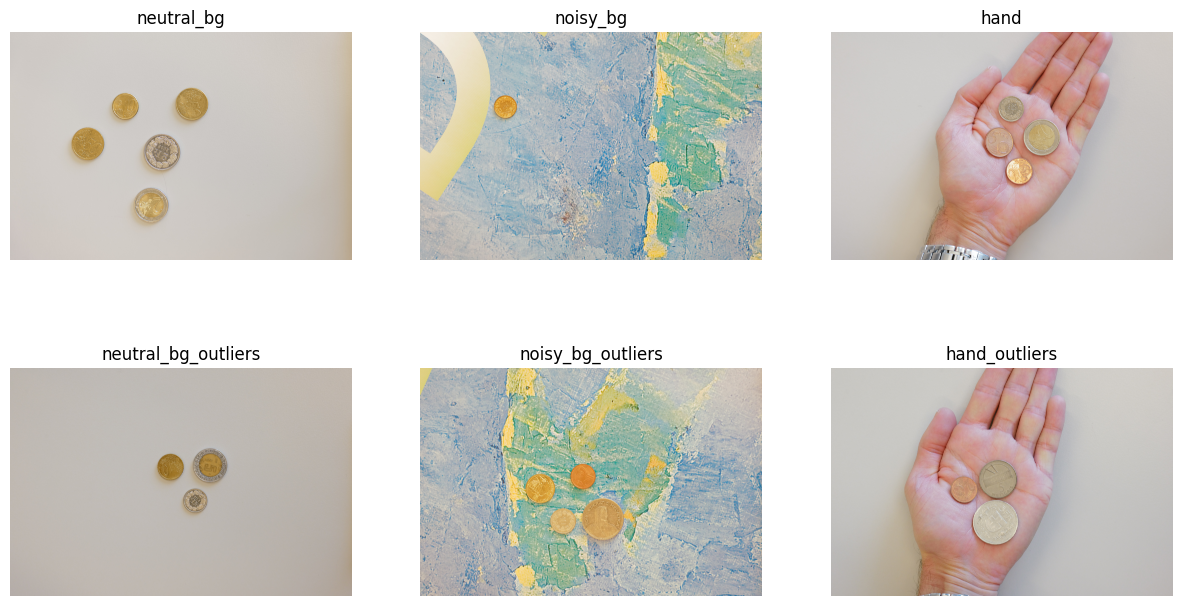

In [5]:
fig = plt.figure(figsize=(15, 8)) 
rows = 2
columns = 3

train_samples_grouped = {}

for i, category in enumerate(train_images_grouped):
    fig.add_subplot(rows, columns, i + 1) 
    plt.imshow(train_images_grouped[category][0])
    plt.axis('off') 
    plt.title(str(category)) 
    train_samples_grouped[category] = train_images_grouped[category][0]

## 1.3 Image segmentation
The goal here is the separate coins from the background. Here are some TODOs:
* Find a proper threshold for all three types of backgrounds
    * Possibly try color analysis (refer to lab 1)
    * Or we may try methods like Otsu?
    * Do we pick one specific RGB channel, or use grayscale (combined)? Concern is some coins are yellow, some are silver...
* After thresholding, there may be small holes here and there. We can try morphological operations
* Another popular method in image segmentation is the watershed algorithm
    * [Watershed - OpenCV](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)
* Apply some sort of filter to the image
    * Possibly median filter, or Gaussian filter 
* Try to do contour detection/object detection/object labeling/localization
    * [All about contour finding - OpenCV](https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html)
    * Here we will also try to find the bounding boxes of the coins

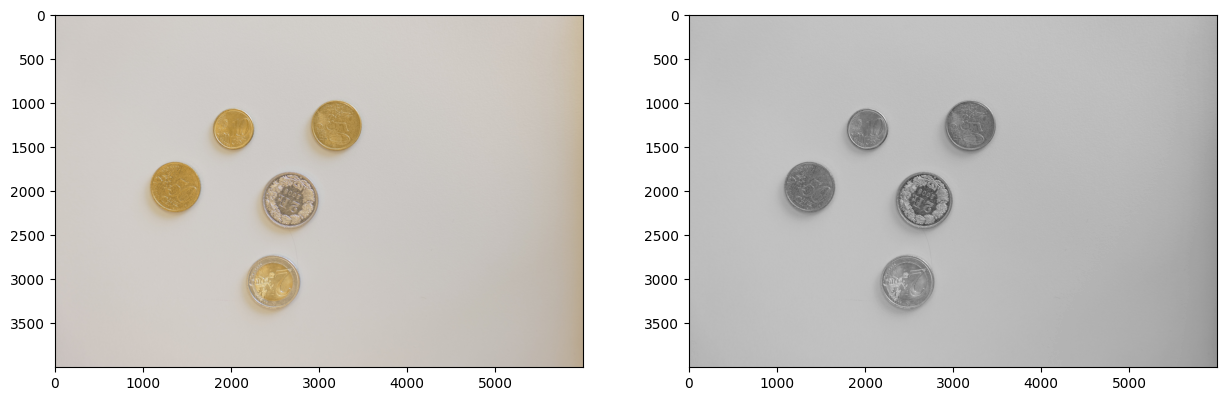

In [6]:
neutral_bg = np.array(train_samples_grouped["neutral_bg"])

# Setting the plot size to 15, 15
plt.figure(figsize=(15, 15))
 
# Sample Image of scikit-image package
plt.subplot(1, 2, 1) 
# Displaying the sample image
plt.imshow(neutral_bg)
 
# Converting RGB image to Monochrome
neutral_bg_grey = ski.color.rgb2gray(neutral_bg)
plt.subplot(1, 2, 2)
# Displaying the sample image - Monochrome
plt.imshow(neutral_bg_grey, cmap="gray")

### Function to test values of thresholds on greyscale image

In [7]:
def test_thresholds(group_name):
  img = np.array(train_samples_grouped[group_name])

  # Setting the plot size to 15, 15
  plt.figure(figsize=(15, 15))
  
  # Converting RGB image to Monochrome
  img_gray = ski.color.rgb2gray(img)

  for i in range(10):
    
    # Iterating different thresholds
    binarized_gray = (img_gray > i*0.1)
    plt.subplot(5,2,i+1)
    
    # Rounding of the threshold
    # value to 1 decimal point
    plt.title("Threshold: >"+str(round(i*0.1,1)))
    
    # Displaying the binarized image
    # of various thresholds
    plt.imshow(binarized_gray, cmap = 'gray')
    
  plt.tight_layout()

### Function to find bounding box of coins of grayscale image

In [13]:
def test_bounding_box(groupName):
    import cv2
    import numpy as np

    # read image
    img = np.array(train_samples_grouped[groupName])

    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold
    thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY_INV)[1]

    # # get contours
    result = img.copy()
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 0, 255), 5)

    plt.imshow(result)